### ______________________________________________________________________________

<div style="width:100%;text-align: center;">
    <img src="ensae.png" /> <br>
    Ecole nationale de la Statistique et de l'Analyse économique Pierre NDIAYE<br>ENSAE - Dakar
    <br>
    <br>
    ***************
    <br>
    <br>
    <strong>Projet de Machine Learning</strong>
    <br>
    <br>
    ***************
    <br>
</div>

<div style="width:100%;text-align: center;">
    <img src="seattle_image.png" style="width:35%;height:100%;" /> <br>
    <span style="font-size:20px;"><strong>SEA Building Energy Benchmarking : Prediction of Building Energy<br>Partie Pré-traitement</strong></span>
</div>
    <br>
    <br>
<div style="display:flex;">
<div style="width:50%;text-align: left;">
   <span style="font-size:20px;">
           Présenté par : <br>
           Mansour Kama SANE <br>
           Sié Charles SOU <br>
           Ulrich DABIRE
    </span>
</div>

<div style="width:50%;text-align: right;">
   <span style="font-size:20px;">
           Sous l'encadrement de : <br>
           Mously DIAW
    </span>
</div>
</div>

### ______________________________________________________________________________

<br>
<br>
<br>
<p style="line-height: 1.8;"> Ce document a été élaboré suite au projet de Machine Learning qui nous a été donné dans le cadre du cours d'Initiation au Machine Learning. Notre travail porte sur <span style="color:blue;"><strong>la prédiction des énergies émises par les bâtiments dans la ville de Seattle<strong></span> </p>

## Introduction

<p>La ville de Seattle, à travers le programme d'analyse comparative de l'énergie des bâtiments de Seattle s'est fixé comme objectif de ville neutre en émissions de carbone en 2050. Pour cela, elle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation. Elle exige des propriétaires de bâtiments non résidentiels et multifamiliaux (20 000 pieds carrés ou plus) qu'ils suivent les performances énergétiques et qu'ils présentent un rapport annuel à la ville de Seattle. L'analyse comparative annuelle, le rapport et la divulgation de la performance des bâtiments sont des éléments fondamentaux de la création d'une plus grande valeur marchande pour l'efficacité énergétique.(Source: <a href="https://data.seattle.gov/browse?q=2015%20Building%20Energy%20Benchmarking&sortBy=relevance" > cliquer ici </a>)</p>
Notre travail consistera, dès lors, à prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées en nous servant des données de 2019 et de 2020. Pour ce faire, le plan suivant a été adopté.
Ce premier Notebook est dédié au Pré-traitement de la base. Pour voir la modélisation <a href="Modelling.ipynb" target="_blank"> Cliquer ici</a>

# Sommaire

* [Preprocessing](#preprocessing)
    * [Description des datasets et concatanation](#caracteristics)
    * [NaN detection et suppression de variables à % de NaN élevé](#nandetec)
    * [Visualisation de l'évolution des variables targets](#targetvisual)
    * [Détection d'anomalies des données](#anomalies)
    * [Imputation des valeurs manquantes par catégorie de variables](#imputation)
    * [Analyse descriptive](#analysedesc)
        * [Visualisation des bâtiments avec folium](#sitefolium)
        * [Visualisation des variables numériques](#visualvarnum)
        * [Recodage et Visualisation des variables catégorielles](#visualvarcat)
        * [Etude des corrélations](#corr)
            * [Entre features et targets](#corrfeattarg)
            * [Entre features seulement](#corrfeat)
    * [Correction des valeurs aberrantes](#aberantes)
    * [Encodage des variables catégorielles en numeric features](#encodage)
    * [Exportation de la base final](#export)

# Preprocessing <a class="anchor" id="preprocessing"></a>

In [1]:
## Installation de packages
##!pip install fancyimpute
## Packages load
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import fancyimpute
from fancyimpute import KNN
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from scipy.stats import *

#### Importation des deux bases (2019 et 2020)

In [2]:
data_2019=pd.read_csv("data/2019_Building_Energy_Benchmarking.csv")
data_2020=pd.read_csv("data/2020_Building_Energy_Benchmarking.csv")

In [3]:
## Voir les dimensions des deux bases
print('2019 :',data_2019.shape, '2020 :',data_2020.shape)

2019 : (3581, 42) 2020 : (3628, 42)


<p>Nous avons 42 variables dans toutes les deux bases. Mais, nous avons 3581 lignes en 2019 et 3628 lignes en 2020. Ce qui peut signifier que des bâtiments se sont ajoutés en 2020.</p>

#### Comparaison des columns des deux bases <a class="anchor" id="caracteristics"></a>

In [4]:
## Nous utiliserons la fonction suivante pour comparer les columns des deux bases
def columns_comparison(data1,data2):
    Data1Columns = list(data1.columns) ## Have data1 columns
    Data2Columns = list(data2.columns) ## Have data2 columns
    Data1ColumnsDiff=[] #columns in Data1 and not in Data2
    Data2ColumnsDiff=[] #columns in Data2 and not in Data1
    SimilarColumns=[]
    for i in Data2Columns:
        if i in Data1Columns:
            SimilarColumns.append(i) ## Similar columns appending
        else:
            Data2ColumnsDiff.append(i) ## Differents columns appending
    for i in Data1Columns:
        if i not in Data2Columns:
            Data1ColumnsDiff.append(i)
    print('2019 :',Data1ColumnsDiff, '2020 :',Data2ColumnsDiff)

In [5]:
columns_comparison(data_2019,data_2020)

2019 : ['PrimaryPropertyType'] 2020 : ['NumberofBuildings']


<p> Puisque ces variables ne seront pas utiles dans la suite, nous les supprimerons.</p>

### Comparaison des nombres de lignes

In [6]:
data_2020.shape[0]-data_2019.shape[0]

47

<div>Il y a 47 buildings qui sont nouvellement enregistrés entre 2019 et 2020</div>

### Concatation des deux bases (2019 & 2020)

In [7]:
MergedData = pd.concat([data_2019,data_2020])

In [8]:
MergedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7209 entries, 0 to 3627
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    7209 non-null   int64  
 1   DataYear                         7209 non-null   int64  
 2   BuildingName                     7209 non-null   object 
 3   BuildingType                     7209 non-null   object 
 4   TaxParcelIdentificationNumber    7209 non-null   object 
 5   Address                          7209 non-null   object 
 6   City                             7207 non-null   object 
 7   State                            7207 non-null   object 
 8   ZipCode                          7098 non-null   float64
 9   Latitude                         7205 non-null   float64
 10  Longitude                        7205 non-null   float64
 11  Neighborhood                     7205 non-null   object 
 12  CouncilDistrictCode 

In [9]:
MergedData.isnull().sum().sort_values(ascending=False)

ThirdLargestPropertyUseTypeGFA     5831
ThirdLargestPropertyUseType        5831
PrimaryPropertyType                3693
NumberofBuildings                  3581
SecondLargestPropertyUseTypeGFA    3391
SecondLargestPropertyUseType       3391
ENERGYSTARScore                    2016
SourceEUIWN(kBtu/sf)                305
SiteEnergyUse(kBtu)                 305
SiteEUIWN(kBtu/sf)                  305
SourceEUI(kBtu/sf)                  246
SiteEnergyUseWN(kBtu)               246
SiteEUI(kBtu/sf)                    246
EPAPropertyType                     160
LargestPropertyUseType              116
LargestPropertyUseTypeGFA           116
ZipCode                             111
GHGEmissionsIntensity                35
TotalGHGEmissions                    35
NaturalGas(kBtu)                     35
Electricity(kBtu)                    35
CouncilDistrictCode                  31
Latitude                              4
Neighborhood                          4
Longitude                             4


### NaN Détection per variable <a class="anchor" id="nandetec"></a>

<AxesSubplot:title={'center':'Proportion de NaN de chaque variable (%)'}>

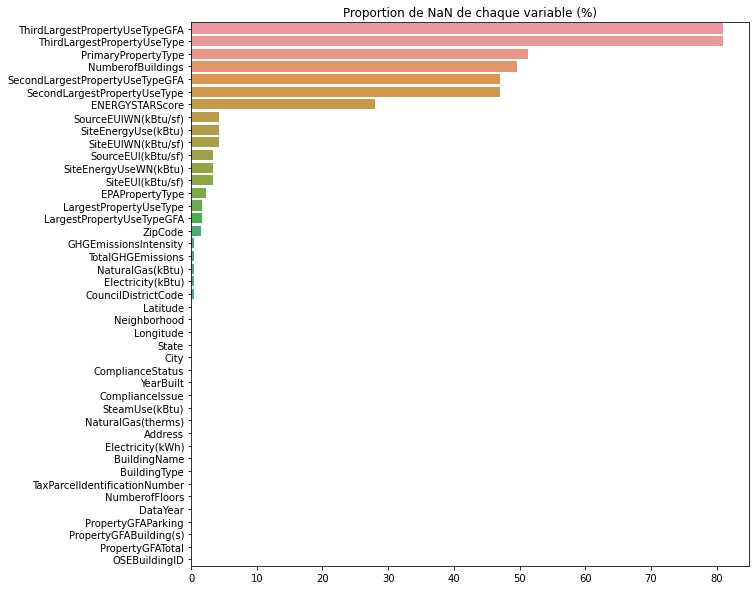

In [10]:
# Check the proportion of NaN value for each column 
plt.figure(figsize=(10,10))
plt.title('Proportion de NaN de chaque variable (%)')
NaNValues=MergedData.isnull().sum().sort_values(ascending=False)
sns.barplot(x=NaNValues.values/MergedData.shape[0]*100, y=NaNValues.index)

<p>Nous constatons que les variables pour lesquelles on a plus de de NaN values sont les deuxième et troisième utilisations les plus importantes d'une propriété (par exemple, un bureau, un magasin de détail) en termes de GFA ainsi que le Score ENERGYSTARS. La proportitions des NaN dépassent les <strong>25%</strong> pour les premiers et les <strong>45%</strong> pour les premiers.</p>

<p>Dans la suite, les variables dont le taux de NaN est élevé à 45% seront supprimées puisque une imputation aura des effets (répercussion) sur notre modèle. Il s'agit des variables :
    <ul>
        <li>'ThirdLargestPropertyUseType' ;</li>
        <li>'ThirdLargestPropertyUseTypeGFA' ;</li>            
        <li>'SecondLargestPropertyUseTypeGFA' ;</li>   
        <li>'SecondLargestPropertyUseType' ;</li>
        <li>'PrimaryPropertyType' ;</li>
        <li>'NumberofBuildings'</li>
    </ul>
</p>

In [11]:
MergedData.shape

(7209, 43)

In [12]:
## Création de la fonction qui permet de supprimer toutes les variables qui ont des NaN values à plus de 45%
def DropNaNSup45(Data):
    x=Data.isnull().sum().sort_values(ascending=False)*100/Data.shape[0]
    x=x[x>45]
    Data.drop(Data.iloc[:,Data.columns.isin(x[x>45].index)==True].columns,axis=1,inplace=True)
    return Data

In [13]:
MergedData=DropNaNSup45(MergedData)

In [14]:
MergedData.shape

(7209, 37)

In [15]:
MergedData.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingName', 'BuildingType',
       'TaxParcelIdentificationNumber', 'Address', 'City', 'State', 'ZipCode',
       'Latitude', 'Longitude', 'Neighborhood', 'CouncilDistrictCode',
       'YearBuilt', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'PropertyGFAParking', 'ENERGYSTARScore',
       'SiteEUIWN(kBtu/sf)', 'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SourceEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'Electricity(kWh)', 'SteamUse(kBtu)', 'NaturalGas(therms)',
       'EPAPropertyType', 'ComplianceStatus', 'ComplianceIssue',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity'],
      dtype='object')

<p> Un autre constat est que certaines variables sont répétées avec des unités différentes.<br>Il s'agit notamment de:
    <ul>
        <li>'Electricity(kWh)' et 'Electricity(kBtu)' ;</li>
        <li>'NaturalGas(therms)' et 'NaturalGas(kBtu)'.</li>
    </ul> 
</p>
<p> On va supprimer l'une des variables et garder l'autre sachant que :
    <ul>
        <li><strong>1th = 100 kBtu</strong></li>
        <li><strong>1 kBTU = 0.293014534 kWh</strong></li>
    </ul>
Certaines variables de l'énergie telles que:
    <ul>
        <li>'SiteEUIWN(kBtu/sf)' et 'SiteEUI(kBtu/sf)' : exprime l'intensité réelle de la consommation d'énergie du bâtiment et celle du bâtiment normalisée par les conditions météorologiques, i.e, celle qu'il aurait consommée dans des conditions météorologiques moyennes sur 30 ans.</li>
        <li>'SiteEnergyUse(kBtu)' et 'SiteEnergyUseWN(kBtu)' : exprime l'utilisation réelle d'énergie du bâtiment et celle du bâtiment normalisée par les conditions météorologiques, i.e, celle qu'il aurait utilisée dans des conditions météorologiques moyennes sur 30 ans.</li>
        <li>'SourceEUIWN(kBtu/sf)' et 'SourceEUI(kBtu/sf)' : exprime l'énergie source réelle du bâtiment et celle du bâtiment normalisée par les conditions météorologiques, i.e, celle qu'il aurait utilisée dans des conditions météorologiques moyennes sur 30 ans.</li>
    </ul>
Nous en profiterons également pour supprimer les variables non unile pour la suite.
Il s'agit des variables suivantes:
    <ul>
        <li>'BuildingName' ;</li>
        <li>'Address' ;</li>            
        <li>'City' ;</li>   
        <li>'State' ;</li>
        <li>'ZipCode' ;</li>
        <li>'CouncilDistrictCode' ;</li>
    </ul>

<u><strong>NB</strong></u> : La description de toutes les variables est faites sur le fichier Excel "<a href="#" target="_blank"><span style="color:green;"><strong>features_chosen.xlsx</strong></span>"</a>

<p style="font-size:18px;"><strong>Suppression des variables répététives et celles qui ne seront pas utilisées dans la suite</strong></p>

In [16]:
BuildingName=MergedData['BuildingName'] ## On en aura besoin dans la suite
LocationInfos=MergedData[['Address','City','State','ZipCode','CouncilDistrictCode']]
MergedData.drop(
    [
    'Electricity(kWh)','NaturalGas(therms)', ## les variables répététives
    'BuildingName',
    'Address',
    'City',
    'State',
    'ZipCode',
    'CouncilDistrictCode'
        ],
    axis=1, inplace=True)

In [17]:
## Voir les modalités de chaque variable catégorielle
def categorial_variables_modalities(Data):
    categorial_variables=Data.select_dtypes(exclude=[np.number])
    for i in categorial_variables.columns:
        print(categorial_variables[i].value_counts())
        print("_"*75)
    ##return categorial_variables

In [18]:
categorial_variables_modalities(MergedData)

NonResidential          2967
Multifamily LR (1-4)    2139
Multifamily MR (5-9)    1419
Multifamily HR (10+)     257
SPS-District K-12        198
Nonresidential COS       133
Campus                    92
Nonresidential WA          4
Name: BuildingType, dtype: int64
___________________________________________________________________________
1625049001    50
0925049346    12
0002400002    10
3224049012    10
7666203240     8
              ..
3573201061     1
2926049039     1
8823902490     1
2249500480     1
1979200050     1
Name: TaxParcelIdentificationNumber, Length: 3553, dtype: int64
___________________________________________________________________________
DOWNTOWN                                                 1214
EAST                                                      971
MAGNOLIA / QUEEN ANNE                                     903
GREATER DUWAMISH                                          741
NORTHEAST                                                 645
LAKE UNION            

## Visualisation de l'évolution des variables cibles <a class="anchor" id="targetvisual"></a>

#### Essayons de visualiser l'évolution de certaines variables au cours des années.

<p> Les émissions de CO2 </p>

In [19]:
MergedData.TotalGHGEmissions.agg(['max','min'])

max    310839.6
min         0.0
Name: TotalGHGEmissions, dtype: float64

(0.0, 500.0)

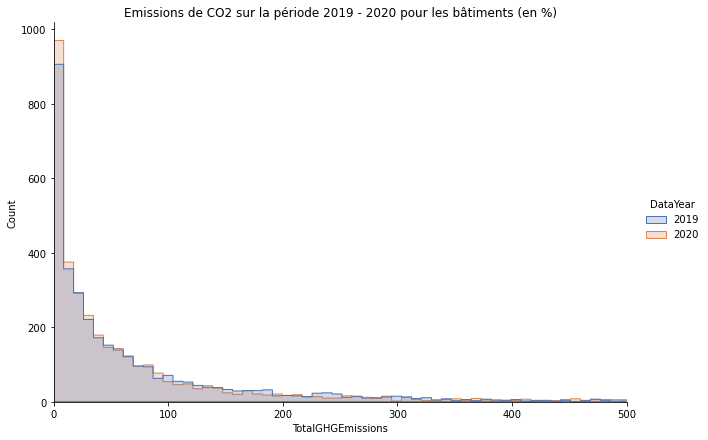

In [20]:
Data2Plot = MergedData[['OSEBuildingID','DataYear','TotalGHGEmissions']].groupby("OSEBuildingID").filter(lambda x: len(x) > 1).sort_values(by='OSEBuildingID')
ThePlot = sns.displot(Data2Plot, x='TotalGHGEmissions', hue='DataYear',element="step", palette='deep', height=6, aspect=1.5)
ThePlot.set(title="Emissions de CO2 sur la période 2019 - 2020 pour les bâtiments (en %)")
plt.xlim(0,500)

<p>On constate une légère évolution des émissions de CO2 par les bâtiments durant la période 2019 - 2020.</p>

<p> La consommation d'énergie des bâtiments</p>

In [21]:
MergedData['SiteEnergyUse(kBtu)'].agg(['max','min'])

max    6.063691e+09
min    0.000000e+00
Name: SiteEnergyUse(kBtu), dtype: float64

(0.0, 30000000.0)

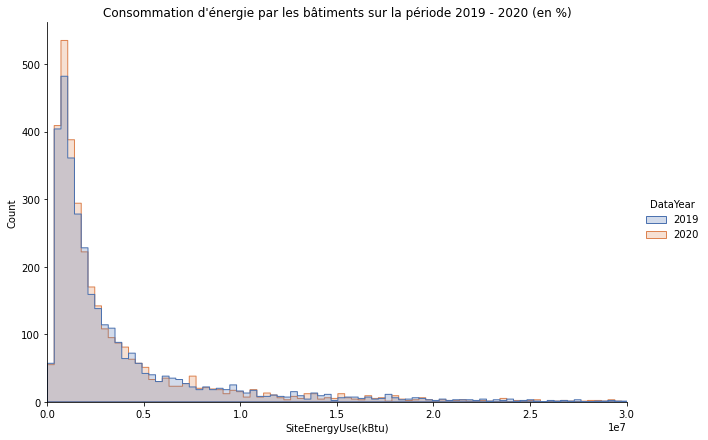

In [22]:
Data2Plot = MergedData[['OSEBuildingID','DataYear','SiteEnergyUse(kBtu)']].groupby("OSEBuildingID").filter(lambda x: len(x) > 1).sort_values(by='OSEBuildingID')
ThePlot = sns.displot(Data2Plot, x='SiteEnergyUse(kBtu)', hue='DataYear',element="step", palette='deep', height=6, aspect=1.5)
ThePlot.set(title="Consommation d'énergie par les bâtiments sur la période 2019 - 2020 (en %)")
plt.xlim(0,0.3e8)

<p> Cette visualisation permet de voir, comme pour les émissions de CO2, une légère évolution de la consommation d'énergie par les bâtiments durant la période 2019 - 2020.</p>

#### Voir une description des variables numériques

In [23]:
## Voir les propriétés des variables numériques pour repérer les éventuelles incorrections
MergedData.select_dtypes(exclude=[np.object_]).describe()

OSEBuildingID     DataYear     Latitude    Longitude    YearBuilt  \
count    7209.000000  7209.000000  7205.000000  7205.000000  7209.000000   
mean    23319.063254  2019.503260    47.624735  -122.334795  1972.199750   
std     13919.184833     0.500024     0.046965     0.027054    34.337899   
min         1.000000  2019.000000    47.499170  -122.414250  1896.000000   
25%     20228.000000  2019.000000    47.601140  -122.350550  1952.000000   
50%     23516.000000  2020.000000    47.619270  -122.332410  1979.000000   
75%     26741.000000  2020.000000    47.657130  -122.318770  2001.000000   
max     50697.000000  2020.000000    47.733870  -122.258640  2019.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFABuilding(s)  \
count     7209.000000      7.209000e+03            7.209000e+03   
mean         4.990706      1.058756e+05            9.029206e+04   
std          5.653989      2.331222e+05            2.111133e+05   
min          0.000000      2.000000e+04            9.660000e+03   
25%          3.000000      2.939400e+04            2.749800e+04   
50%          4.000000      4.687300e+04            4.364500e+04   
75%          6.000000      9.993100e+04            8.844900e+04   
max         76.000000      9.320156e+06            9.320156e+06   

       PropertyGFAParking  ENERGYSTARScore  ...  SiteEnergyUse(kBtu)  \
count         7209.000000      5193.000000  ...         6.904000e+03   
mean         15583.517825        73.116696  ...         6.139201e+06   
std          46244.445727        24.797047  ...         7.470348e+07   
min             -3.000000         1.000000  ...         0.000000e+00   
25%              0.000000        60.000000  ...         9.604658e+05   
50%              0.000000        80.000000  ...         1.862802e+06   
75%           8656.000000        93.000000  ...         4.294009e+06   
max         686750.000000       100.000000  ...         6.063691e+09   

       SiteEnergyUseWN(kBtu)  SourceEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
count           6.963000e+03           6904.000000         6963.000000   
mean            6.076237e+06            118.117280          117.094097   
std             7.198807e+07            290.525338          281.688955   
min             0.000000e+00              0.000000            0.000000   
25%             9.472790e+05             67.600000           66.700000   
50%             1.842312e+06             85.400000           84.300000   
75%             4.263687e+06            119.700000          118.950000   
max             5.859773e+09          21839.400000        21107.600000   

       LargestPropertyUseTypeGFA  SteamUse(kBtu)  Electricity(kBtu)  \
count               7.093000e+03    7.209000e+03       7.174000e+03   
mean                8.580018e+04    1.124141e+06       3.358224e+06   
std                 2.476245e+05    6.896455e+07       9.343967e+06   
min                 5.100000e+03    0.000000e+00       0.000000e+00   
25%                 2.591400e+04    0.000000e+00       6.140072e+05   
50%                 4.170600e+04    0.000000e+00       1.145100e+06   
75%                 8.209800e+04    0.000000e+00       2.711336e+06   
max                 1.521647e+07    5.845455e+09       2.705582e+08   

       NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
count      7.174000e+03        7174.000000            7174.000000  
mean       1.427135e+06         159.610636               1.290549  
std        7.426007e+06        3705.643839              11.097917  
min        0.000000e+00           0.000000               0.000000  
25%        0.000000e+00           7.700000               0.200000  
50%        3.376005e+05          32.100000               0.600000  
75%        1.269681e+06          90.300000               1.400000  
max        3.880064e+08      310839.600000             927.700000  

[8 rows x 22 columns]

<p>On constate qu'il y a des bâtiments pour lesquelles l'Espace total en pieds carrés de tous les types de stationnement (PropertyGFAParking) est négatif. Pour d'autres bâtiments, la consommation d'énergie, l'énergie source, l'électricité, les émissions de CO2... sont renseignés à 0.0</p>
<p>Enumérons ces erreurs</p>

## Détection d'anomalies des données <a class="anchor" id="anomalies"></a>

In [24]:
## PropertyGFAParking négatif
MergedData[MergedData.PropertyGFAParking<0]

OSEBuildingID  DataYear    BuildingType TaxParcelIdentificationNumber  \
3272          49970      2019  NonResidential                    1625049001   
3243          49970      2020  NonResidential                    1625049001   

      Latitude  Longitude Neighborhood  YearBuilt  NumberofFloors  \
3272  47.65718 -122.31632    NORTHEAST       2011               0   
3243  47.65718 -122.31632    NORTHEAST       2011               0   

      PropertyGFATotal  ...    LargestPropertyUseType  \
3272            176225  ...  Residence Hall/Dormitory   
3243            176225  ...  Residence Hall/Dormitory   

      LargestPropertyUseTypeGFA  SteamUse(kBtu)           EPAPropertyType  \
3272                   176225.0               0  Residence Hall/Dormitory   
3243                   176225.0               0  Residence Hall/Dormitory   

      ComplianceStatus  ComplianceIssue  Electricity(kBtu)  NaturalGas(kBtu)  \
3272         Compliant         No Issue          3530243.0         1714995.0   
3243         Compliant         No Issue          3147652.0         1421892.0   

      TotalGHGEmissions GHGEmissionsIntensity  
3272              112.8                   0.6  
3243               92.3                   0.5  

[2 rows x 29 columns]

<p>
    Il s'agit donc du bâtiment d'identifiant <strong>49970</strong>.
</p>

In [25]:
## Bâtiments pour lesquels l'énergie source est nulle
MergedData[MergedData['SourceEUI(kBtu/sf)']<=0]

OSEBuildingID  DataYear    BuildingType TaxParcelIdentificationNumber  \
785          19876      2019  NonResidential                    0656000215   

     Latitude  Longitude Neighborhood  YearBuilt  NumberofFloors  \
785  47.61543 -122.34651     DOWNTOWN       1954               2   

     PropertyGFATotal  ...  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
785             28696  ...                   Other                    12960.0   

     SteamUse(kBtu)     EPAPropertyType  ComplianceStatus  \
785               0  Mixed Use Property     Not Compliant   

                          ComplianceIssue  Electricity(kBtu)  \
785  Missing 2019 EUI or Electricity Data                0.0   

     NaturalGas(kBtu)  TotalGHGEmissions GHGEmissionsIntensity  
785               0.0                0.0                   0.0  

[1 rows x 29 columns]

<p>Il s'agit du bâtiment d'identifiant <strong>19876</strong> en <strong>2019</strong></p>

### Revenons aux valeurs manquantes <a class="anchor" id="imputation"></a>

<p>Il s'agira de trouver une méthode d'imputation de ces valeurs manquantes.</p>
<p>Dans le cadre de notre travail, il s'agira de faire une imputation par catégorie de variables :
<ul>
    <li> Pour les variables numériques, nous procéderons à une imputation par la méthode de KNN imputer</li>;
    <li> Par rapport aux variables catégorielles, nous utiliserons le <strong>mode</strong> pour faire l'imputation des valeurs manquantes des variables à moins de 5% de pourcentage. Et pour le reste, nous utiliserons le KNN imputer too.</li>
</ul>
</p>
<p>
    <strong>Pourquoi le KNN Imputer ?</strong><br>
L'idée des méthodes kNN est d'identifier "k" échantillons dans l'ensemble de données qui sont similaires ou proches dans l'espace. Ensuite, nous utilisons ces échantillons "k" pour estimer la valeur des points de données manquants. Les valeurs manquantes de chaque échantillon sont imputées en utilisant la valeur moyenne des 'k'-voisins trouvés dans l'ensemble de données.(Source: <a href="https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/#:~:text=The%20idea%20in%20kNN%20methods,neighbors%20found%20in%20the%20dataset." target="_blank">Cliquer ici pour plus d'information</a>).<br>
</p>

<p>
    <strong>Pourquoi le mode ?</strong><br>
L'imputation par mode consiste à remplacer toutes les occurrences de NaN values NaN au sein d'une variable par le mode, qui en d'autres termes désigne la valeur la plus fréquente ou la catégorie la plus fréquente.<br>C'est une méthode facile à mettre en œuvre et c'est le moyen le plus rapide d'obtenir des jeux de données complets. Elle est utilisé, dans la plupart des cas, quand pas plus de <strong>5%</strong> de la variable contient des données manquantes car présentant les limites suivantes:
    <ul>
        <li>Il déforme la relation entre l'étiquette la plus fréquente et les autres variables de l'ensemble de données </li>
        <li>Elle peut conduire à une surreprésentation de l'étiquette la plus fréquente s'il y a un grand nombre de NA</li>
    </ul>
    Pour plus d'information : <a href="https://medium.com/geekculture/frequent-category-imputation-missing-data-imputation-technique-4d7e2b33daf7" target="_blank">Cliquer ici</a>
</p>

In [26]:
## Imputation des variables numériques
num=[col for col in MergedData.columns if MergedData[col].dtypes!='O']
categorial=[col for col in MergedData.columns if MergedData[col].dtypes=='O']

##### Les variables numériques

In [27]:
MergedData[num]

OSEBuildingID  DataYear  Latitude  Longitude  YearBuilt  NumberofFloors  \
0                 1      2019  47.61220 -122.33799       1927              12   
1                 2      2019  47.61317 -122.33393       1996              11   
2                 3      2019  47.61367 -122.33822       1969              41   
3                 5      2019  47.61412 -122.33664       1926              10   
4                 8      2019  47.61375 -122.34047       1980              18   
...             ...       ...       ...        ...        ...             ...   
3623          50690      2020  47.69996 -122.34505       2019               6   
3624          50692      2020  47.61875 -122.35523       2018               7   
3625          50693      2020  47.65019 -122.36173       1960               3   
3626          50694      2020  47.61598 -122.30770       2002               7   
3627          50697      2020  47.66964 -122.37918       2018               6   

      PropertyGFATotal  PropertyGFABuilding(s)  PropertyGFAParking  \
0                88434                   88434                   0   
1               103566                   88502               15064   
2               956110                  759392              196718   
3                61320                   61320                   0   
4               175580                  113580               62000   
...                ...                     ...                 ...   
3623            213065                  213065                   0   
3624            182411                  138533               43878   
3625             20289                   20289                   0   
3626            183379                  136682               46697   
3627            189044                  146239               42805   

      ENERGYSTARScore  ...  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0                62.0  ...            7363218.0              7351864.0   
1                70.0  ...            8040648.0              8006404.0   
2                64.0  ...           68355568.0             68103264.0   
3                58.0  ...            6346838.0              6319004.0   
4                63.0  ...           15875107.0             15875107.0   
...               ...  ...                  ...                    ...   
3623              NaN  ...                  NaN                    NaN   
3624              NaN  ...            3250235.0              3211659.0   
3625              NaN  ...            2211138.0              2111309.0   
3626             74.0  ...            6643564.0              6543062.0   
3627             98.0  ...            4056120.0              4056120.0   

      SourceEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  LargestPropertyUseTypeGFA  \
0                    167.6               167.6                    88434.0   
1                    153.7               153.3                    83880.0   
2                    201.5               201.1                   756493.0   
3                    177.5               176.3                    61320.0   
4                    212.2               212.2                   123445.0   
...                    ...                 ...                        ...   
3623                   NaN                 NaN                   226973.0   
3624                  71.2                70.9                   113351.0   
3625                 195.2               188.1                    18289.0   
3626                  86.0                85.3                   105997.0   
3627                  55.8                55.8                   159080.0   

      SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
0            2159078          3871996.0         1320791.0              208.8   
1                  0          2946902.0         5059502.0              286.9   
2           22601024         44075841.0         1426400.0             1549.0   
3            2104444          2201145.0         2013415.0 

##### Les variables catégorielles

In [28]:
MergedData[categorial]

BuildingType TaxParcelIdentificationNumber  \
0           NonResidential                    0659000030   
1           NonResidential                    0659000220   
2           NonResidential                    0659000475   
3           NonResidential                    0659000640   
4           NonResidential                    0659000970   
...                    ...                           ...   
3623        NonResidential                    0306000570   
3624  Multifamily MR (5-9)                    1989201430   
3625        NonResidential                    0000000000   
3626  Multifamily MR (5-9)                    7234601325   
3627  Multifamily MR (5-9)                    2767700430   

               Neighborhood LargestPropertyUseType        EPAPropertyType  \
0                  DOWNTOWN                  Hotel                  Hotel   
1                  DOWNTOWN                  Hotel                  Hotel   
2                  DOWNTOWN                  Hotel                  Hotel   
3                  DOWNTOWN                  Hotel                  Hotel   
4                  DOWNTOWN                  Hotel                  Hotel   
...                     ...                    ...                    ...   
3623              NORTHWEST  Self-Storage Facility  Self-Storage Facility   
3624  MAGNOLIA / QUEEN ANNE    Multifamily Housing   Multifamily MR (5-9)   
3625  MAGNOLIA / QUEEN ANNE     College/University     College/University   
3626                CENTRAL    Multifamily Housing   Multifamily MR (5-9)   
3627                BALLARD    Multifamily Housing   Multifamily MR (5-9)   

     ComplianceStatus ComplianceIssue  
0           Compliant        No Issue  
1           Compliant        No Issue  
2           Compliant        No Issue  
3           Compliant        No Issue  
4           Compliant        No Issue  
...               ...             ...  
3623        Compliant        No Issue  
3624        Compliant        No Issue  
3625        Compliant        No Issue  
3626        Compliant        No Issue  
3627        Compliant        No Issue  

[7209 rows x 7 columns]

### Imputation des valeurs numériques par la méthode KNNImputer

In [29]:
## Définition de la fonction knn
knn=KNNImputer(n_neighbors=5 ##,add_indicator=True
              )
               ## add_indicator pour dire donner une indication que la ligne 
                ## contienait bien une valeur manquante

In [30]:
knn.fit(MergedData[num])

KNNImputer()

In [31]:
pd.DataFrame(knn.transform(MergedData[num]))

0       1         2          3       4     5         6         7   \
0         1.0  2019.0  47.61220 -122.33799  1927.0  12.0   88434.0   88434.0   
1         2.0  2019.0  47.61317 -122.33393  1996.0  11.0  103566.0   88502.0   
2         3.0  2019.0  47.61367 -122.33822  1969.0  41.0  956110.0  759392.0   
3         5.0  2019.0  47.61412 -122.33664  1926.0  10.0   61320.0   61320.0   
4         8.0  2019.0  47.61375 -122.34047  1980.0  18.0  175580.0  113580.0   
...       ...     ...       ...        ...     ...   ...       ...       ...   
7204  50690.0  2020.0  47.69996 -122.34505  2019.0   6.0  213065.0  213065.0   
7205  50692.0  2020.0  47.61875 -122.35523  2018.0   7.0  182411.0  138533.0   
7206  50693.0  2020.0  47.65019 -122.36173  1960.0   3.0   20289.0   20289.0   
7207  50694.0  2020.0  47.61598 -122.30770  2002.0   7.0  183379.0  136682.0   
7208  50697.0  2020.0  47.66964 -122.37918  2018.0   6.0  189044.0  146239.0   

            8     9   ...          12          13     14      15        16  \
0          0.0  62.0  ...   7363218.0   7351864.0  167.6  167.60   88434.0   
1      15064.0  70.0  ...   8040648.0   8006404.0  153.7  153.30   83880.0   
2     196718.0  64.0  ...  68355568.0  68103264.0  201.5  201.10  756493.0   
3          0.0  58.0  ...   6346838.0   6319004.0  177.5  176.30   61320.0   
4      62000.0  63.0  ...  15875107.0  15875107.0  212.2  212.20  123445.0   
...        ...   ...  ...         ...         ...    ...     ...       ...   
7204       0.0  84.0  ...  15201665.6  15321573.6  159.4  160.34  226973.0   
7205   43878.0  67.2  ...   3250235.0   3211659.0   71.2   70.90  113351.0   
7206       0.0  50.4  ...   2211138.0   2111309.0  195.2  188.10   18289.0   
7207   46697.0  74.0  ...   6643564.0   6543062.0   86.0   85.30  105997.0   
7208   42805.0  98.0  ...   4056120.0   4056120.0   55.8   55.80  159080.0   

              17          18          19       20    21  
0      2159078.0   3871996.0   1320791.0   208.80  2.40  
1            0.0   2946902.0   5059502.0   286.90  3.20  
2     22601024.0  44075841.0   1426400.0  1549.00  2.00  
3      2104444.0   2201145.0   2013415.0   232.40  3.80  
4            0.0   5444815.0  10430292.0   587.50  5.20  
...          ...         ...         ...      ...   ...  
7204         0.0  10069218.6    940887.4   107.48  0.52  
7205         0.0   2796535.0    415123.0    36.90  0.30  
7206         0.0    914426.0   1196883.0    68.40  3.40  
7207         0.0   2733787.0   3809275.0   216.80  1.60  
7208         0.0   2639858.0   1416262.0    89.30  0.60  

[7209 rows x 22 columns]

In [32]:
NumImputed=pd.DataFrame(knn.transform(MergedData[num]))

In [33]:
NumImputed.columns=num

In [34]:
NumImputed.index=MergedData.index

In [35]:
NumImputed.isnull().sum()

OSEBuildingID                0
DataYear                     0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofFloors               0
PropertyGFATotal             0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
ENERGYSTARScore              0
SiteEUIWN(kBtu/sf)           0
SiteEUI(kBtu/sf)             0
SiteEnergyUse(kBtu)          0
SiteEnergyUseWN(kBtu)        0
SourceEUIWN(kBtu/sf)         0
SourceEUI(kBtu/sf)           0
LargestPropertyUseTypeGFA    0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
GHGEmissionsIntensity        0
dtype: int64

In [36]:
target_var=['TotalGHGEmissions','SiteEnergyUse(kBtu)']
for i in target_var:
    print(NumImputed[i].agg([min,max]))
    print("_"*25)

min         0.0
max    310839.6
Name: TotalGHGEmissions, dtype: float64
_________________________
min    0.000000e+00
max    6.063691e+09
Name: SiteEnergyUse(kBtu), dtype: float64
_________________________


Nous constatons que nos target features contiennent des valeurs nulles. Il s'agit des lignes suivantes:

In [37]:
TargetVarNull=NumImputed[target_var].loc[(NumImputed[target_var[0]]==0) | 
                                         (NumImputed[target_var[1]]==0),:].sort_values(
    by=target_var[1],ascending=True)
TargetVarNull

TotalGHGEmissions  SiteEnergyUse(kBtu)
785                 0.0                  0.0
2936                0.0               2471.0
1793                0.0               7332.0
3419                0.0               8731.0
3546                0.0               8731.0
...                 ...                  ...
68                  0.0             190281.0
295                 0.0             268226.2
3505                0.0             532245.0
742                 0.0             625573.0
1781                0.0            1944661.2

[159 rows x 2 columns]

Nous allons imputer ces valeurs nulles par la méthode du KNNImputed. Pour se faire, nous allons d'abord transformer ces valeurs en NaN values puis appliquer la fonction knn.transform()

In [38]:
for var in target_var:
    NumImputed[var].replace(0.0,np.NaN,inplace=True)

In [39]:
NumImputed[target_var].loc[(NumImputed[target_var[0]].isnull()==True) | 
                                         (NumImputed[target_var[1]].isnull()==True),:].sort_values(
    by=target_var[1],ascending=True)

TotalGHGEmissions  SiteEnergyUse(kBtu)
2936                NaN               2471.0
1793                NaN               7332.0
3419                NaN               8731.0
3546                NaN               8731.0
3555                NaN               8731.0
...                 ...                  ...
295                 NaN             268226.2
3505                NaN             532245.0
742                 NaN             625573.0
1781                NaN            1944661.2
785                 NaN                  NaN

[159 rows x 2 columns]

In [40]:
## Désormais appliquons la fonction du KNNImputer
knn.fit(NumImputed)
NumImputed=pd.DataFrame(knn.transform(NumImputed))
NumImputed.columns=num
NumImputed.index=MergedData.index

In [41]:
NumImputed[target_var][NumImputed.index.isin(TargetVarNull.index)].sort_values(by=target_var[1])

TotalGHGEmissions  SiteEnergyUse(kBtu)
2936               0.26               2471.0
1793               0.26               7332.0
3546               0.26               8731.0
3419               0.26               8731.0
3555               0.26               8731.0
...                 ...                  ...
3227            1259.00           30212058.0
3505             165.90           31934638.0
3414             672.90           39779848.0
3570            1620.70           58184440.0
3482             709.00          129572976.0

[307 rows x 2 columns]

<p style="font-size:20px"><strong>Imputation des valeurs manquantes des variables catégorielles par le mode pour les variables à pourcentage de NaN inférieure à 5% et par la méthode du KNNImputer pour les autres</strong></p>

In [42]:
x=MergedData[categorial].isnull().sum().sort_values(ascending=False)*100/MergedData.shape[0]
x<5

EPAPropertyType                  True
LargestPropertyUseType           True
Neighborhood                     True
BuildingType                     True
TaxParcelIdentificationNumber    True
ComplianceStatus                 True
ComplianceIssue                  True
dtype: bool

<p>Apparemment toutes les variables catégorielles sont à pourcentage de NaN inférieure à <strong>5%</strong>. C'est d'ailleurs ce qui va nous permettre d'imputer par le <strong>mode</strong>.</p>

In [43]:
## Imputation colonne par colonne
def ImputationByMode(Data):
    for i in Data.columns:
        Data[i].fillna(Data[i].mode()[0],inplace=True)
    return Data

In [44]:
## Test
CategorialData=MergedData[categorial]

In [45]:
CategorialData=ImputationByMode(CategorialData)

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [46]:
CategorialData.isnull().sum()

BuildingType                     0
TaxParcelIdentificationNumber    0
Neighborhood                     0
LargestPropertyUseType           0
EPAPropertyType                  0
ComplianceStatus                 0
ComplianceIssue                  0
dtype: int64

#### L'imputation est faite pour les deux catégories de variables

## Analyse descriptive <a class="anchor" id="analysedesc"></a>

#### Visualisation des bâtiments <a class="anchor" id="sitefolium"></a>

In [47]:
import folium
from folium import plugins

In [48]:
data_map = folium.Map(location=MergedData[['Latitude','Longitude']].mean().tolist(), zoom_start=12)

In [49]:
marker_cluster = plugins.MarkerCluster().add_to(data_map)

# Add markers to the marker cluster for each data point
for row in range(MergedData.shape[0]):
    folium.Marker(
        location=list(NumImputed[['Latitude','Longitude']].iloc[row].values),
        popup=BuildingName.iloc[row],  # Popup text is in a column of the dataframe
    ).add_to(marker_cluster)
##st.markdown(data_map._repr_html_(), unsafe_allow_html=True)
# Display the map
data_map

### Pour les variables numériques <a class="anchor" id="visualvarnum"></a>

In [50]:
NumImputed.columns

Index(['OSEBuildingID', 'DataYear', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)',
       'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'SourceEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'LargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

<p>Nous ferons l'analyse descriptive des variables suivantes:</p>
<ul>
    <li>'ENERGYSTARScore',</li>
    <li>'SiteEUI(kBtu/sf)' et 'SiteEUIWN(kBtu/sf)',</li>
    <li>'SiteEnergyUse(kBtu)' et 'SiteEnergyUseWN(kBtu)',</li>
    <li>'SourceEUI(kBtu/sf)' et 'SourceEUIWN(kBtu/sf)',</li>
    <li>'SteamUse(kBtu)',</li>
    <li>'Electricity(kBtu)',</li>
    <li>'NaturalGas(kBtu)',</li>
    <li>'TotalGHGEmissions',</li>
    <li>'GHGEmissionsIntensity'</li>
</ul>

In [51]:
col=[
'ENERGYSTARScore',
'SteamUse(kBtu)',
'Electricity(kBtu)',
'NaturalGas(kBtu)',
'TotalGHGEmissions',
'GHGEmissionsIntensity'
]

##'SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)',

##### Distribution des intensités d'énergies (réelle consommée et celle normalisée par les conditions météorologiques

(0.0, 400.0)

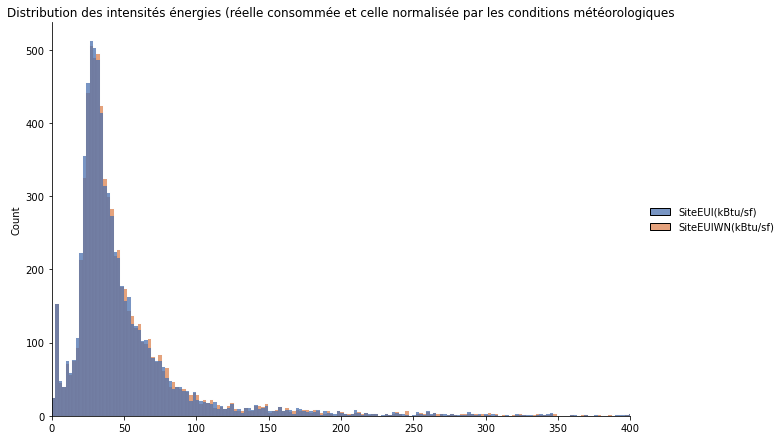

In [52]:
ThePlot = sns.displot(NumImputed[['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)']],  palette='deep', height=6, aspect=1.5)
ThePlot.set(title="Distribution des intensités énergies (réelle consommée et celle normalisée par les conditions météorologiques")
plt.xlim(0,400)

<p>A travers ce graphique, on soupçonne une corrélation significative entre ces deux features.</p>

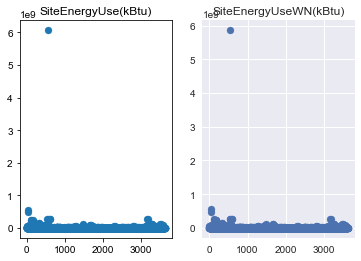

In [53]:
from matplotlib import rcParams
plt.subplot(1,2,1)
plt.title('SiteEnergyUse(kBtu)')
plt.style.use('seaborn')
plt.scatter(MergedData.index, MergedData['SiteEnergyUse(kBtu)'])
plt.subplot(1,2,2)
plt.title('SiteEnergyUseWN(kBtu)')
plt.style.use('seaborn')
plt.scatter(MergedData.index, MergedData['SiteEnergyUseWN(kBtu)'])

<p>Nous soupçonnons à travers ces figures des valeurs abérentes pour les deux variables. Mais, nous pouvons également soupçons une corrélation significative entre ces deux variables. </p>

#### BoxPlot des variables numériques

In [54]:
def NumVarBoxPlot(Data):
    for columns in Data.columns:
        plt.figure(figsize = (8,1))
        sns.boxplot(x = Data[columns])
        titre = 'Répartition de : '+ columns
        plt.title(titre)
        plt.xlabel(columns)
        plt.show()
    sns.set(font_scale = 1)

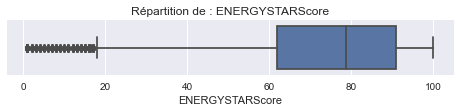

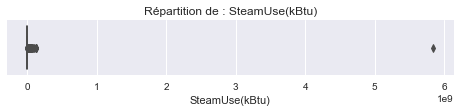

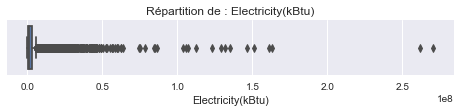

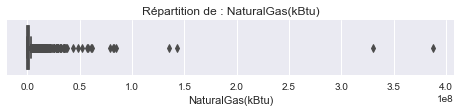

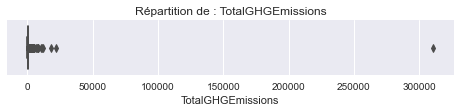

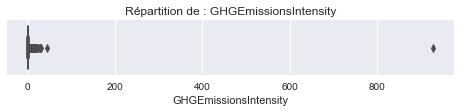

In [55]:
NumVarBoxPlot(NumImputed[col])

## Recodage et visualisation des variables catégorielles <a class="anchor" id="visualvarcat"></a>

In [56]:
CategorialData.columns

Index(['BuildingType', 'TaxParcelIdentificationNumber', 'Neighborhood',
       'LargestPropertyUseType', 'EPAPropertyType', 'ComplianceStatus',
       'ComplianceIssue'],
      dtype='object')

In [57]:
categorial_variables_modalities(MergedData)

NonResidential          2967
Multifamily LR (1-4)    2139
Multifamily MR (5-9)    1419
Multifamily HR (10+)     257
SPS-District K-12        198
Nonresidential COS       133
Campus                    92
Nonresidential WA          4
Name: BuildingType, dtype: int64
___________________________________________________________________________
1625049001    50
0925049346    12
0002400002    10
3224049012    10
7666203240     8
              ..
3573201061     1
2926049039     1
8823902490     1
2249500480     1
1979200050     1
Name: TaxParcelIdentificationNumber, Length: 3553, dtype: int64
___________________________________________________________________________
DOWNTOWN                                                 1214
EAST                                                      971
MAGNOLIA / QUEEN ANNE                                     903
GREATER DUWAMISH                                          741
NORTHEAST                                                 645
LAKE UNION            

<p>Dans la suite, nous ferons le recodage de certaines variables qui ont beaucoup de modalités</p>

In [58]:
CategorialData["BuildingType"].replace(['Multifamily LR (1-4)','Multifamily MR (5-9)','Multifamily HR (10+)'],"Multifamily",inplace=True)
CategorialData["BuildingType"].replace(['Nonresidential WA','Nonresidential COS'],"NonResidential",inplace=True)
CategorialData["EPAPropertyType"].replace(['Multifamily LR (1-4)','Multifamily MR (5-9)','Multifamily HR (10+)'],"Multifamily",inplace=True)

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [59]:
##Recodage des variables
def recodage(Data):
    for i in Data.columns:
        if i!="BuildingType":
            for j in list(Data[i].unique()):
                if Data[i][Data[i]==j].value_counts()[0]<100:
                    ##Data[Data[i]==j][i].replace(j,"Autres",inplace=True)
                    Data[i].replace(j,"Autres_"+i,inplace=True)
    return Data

In [60]:
CategorialData=recodage(CategorialData)

In [61]:
categorial_variables_modalities(CategorialData)

Multifamily          3815
NonResidential       3104
SPS-District K-12     198
Campus                 92
Name: BuildingType, dtype: int64
___________________________________________________________________________
Autres_TaxParcelIdentificationNumber    7209
Name: TaxParcelIdentificationNumber, dtype: int64
___________________________________________________________________________
DOWNTOWN                  1218
EAST                       971
MAGNOLIA / QUEEN ANNE      903
GREATER DUWAMISH           741
NORTHEAST                  645
LAKE UNION                 557
NORTHWEST                  441
SOUTHWEST                  355
NORTH                      302
BALLARD                    281
CENTRAL                    221
SOUTHEAST                  205
Autres_Neighborhood        202
DELRIDGE NEIGHBORHOODS     167
Name: Neighborhood, dtype: int64
___________________________________________________________________________
Multifamily Housing              3798
Autres_LargestPropertyUseType    10

<p>La variable EPAPropertyType représente les sous-types de propriété des bâtiments. Pendant que la variables LargestPropertyUseType renseigne sur le type de propriété du bâtiment en tant que tel. En plus, les mêmes modalités des deux variables ont quasiment les même effectifs. Ains, nous supprimerons la variable EPAPropertyType.</p>

In [62]:
EPAPropertyType=CategorialData.EPAPropertyType
TaxParcelIdentificationNumber=CategorialData.TaxParcelIdentificationNumber
CategorialData.drop(['EPAPropertyType','TaxParcelIdentificationNumber'],axis=1,inplace=True)

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Visualisation des variables catégorielles

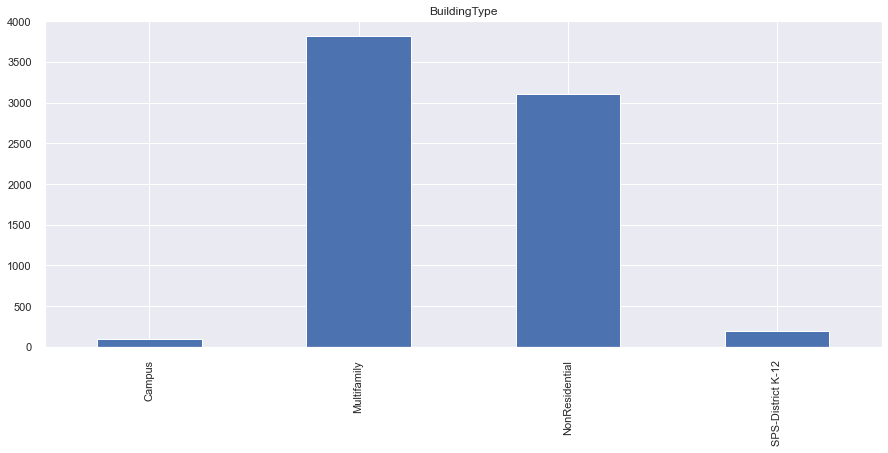

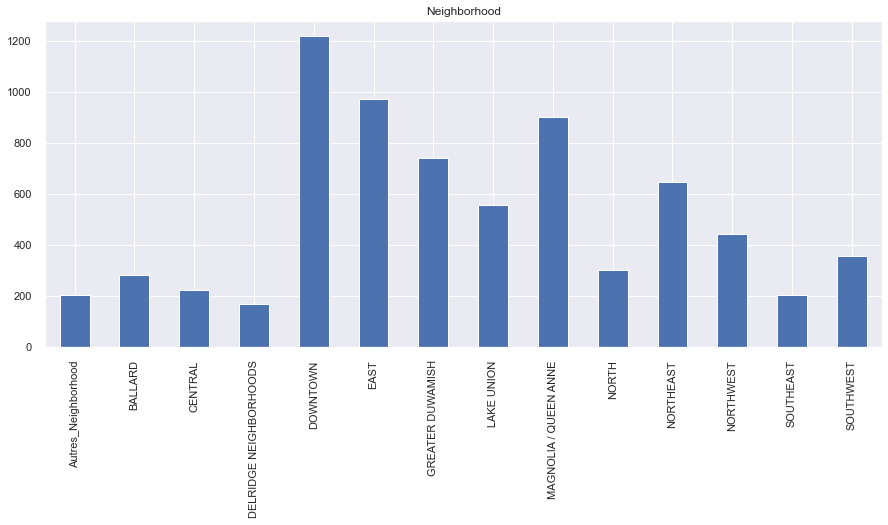

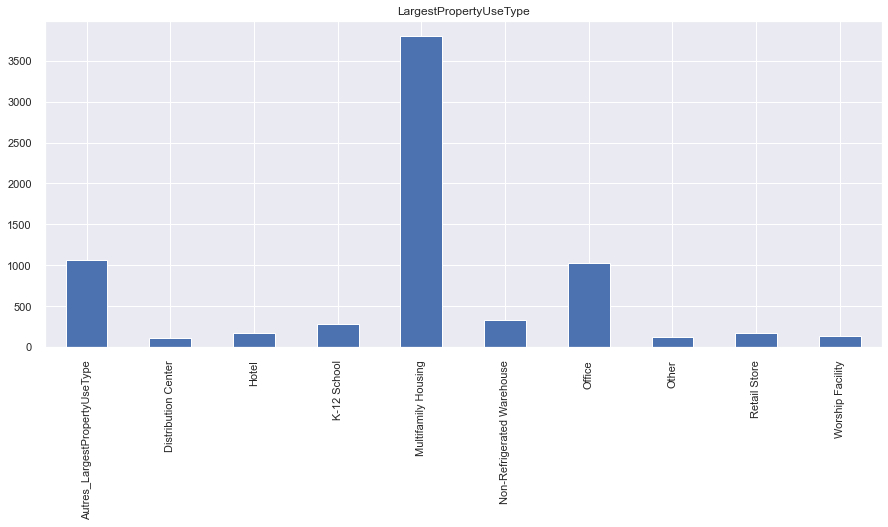

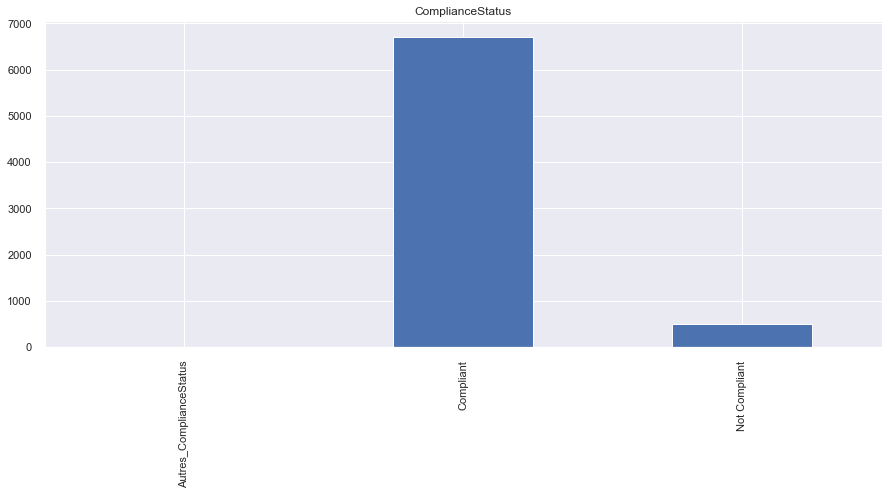

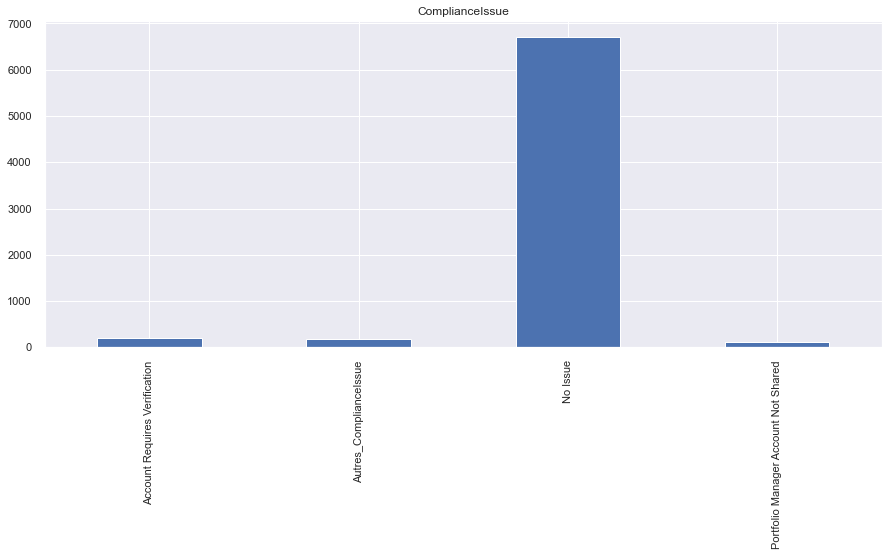

In [63]:
for column in CategorialData.columns:
    fig = plt.figure(figsize=(15,6))
    CategorialData[column].value_counts().sort_index(axis=0).plot(kind='bar')
    plt.title(column)
    plt.show()

## Corrélation des variables <a class="anchor" id="corr"></a>

### Entre features et targets <a class="anchor" id="corrfeattarg"></a>

<p>Les target features (les variables cibles) sont "TotalGHGEmissions" et "SiteEnergyUse(kBtu)". Nous allons les isolées de notre jeux de données en les attribuant à la variable "target"</p>

In [64]:
target = NumImputed[["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]]
target1 = target["TotalGHGEmissions"]
target2 = target["SiteEnergyUse(kBtu)"]

In [65]:
NumImputed.drop(target, axis = 1, inplace = True)

<p> Corrélations entre les variables numérique et la variable cible numéro 1 nommée target1 </p>

In [66]:
NumImputed["target1"] = target["TotalGHGEmissions"]  
correlation1 = NumImputed.corr()["target1"].sort_values()
correlation1

ENERGYSTARScore             -0.050195
OSEBuildingID               -0.027409
DataYear                    -0.013015
YearBuilt                   -0.011852
Latitude                    -0.006922
Longitude                    0.005339
PropertyGFAParking           0.030570
NumberofFloors               0.046239
LargestPropertyUseTypeGFA    0.049627
PropertyGFATotal             0.070138
PropertyGFABuilding(s)       0.070753
Electricity(kBtu)            0.105847
NaturalGas(kBtu)             0.111515
SourceEUI(kBtu/sf)           0.898016
SourceEUIWN(kBtu/sf)         0.903888
SiteEUI(kBtu/sf)             0.967283
SiteEUIWN(kBtu/sf)           0.968950
GHGEmissionsIntensity        0.985427
SteamUse(kBtu)               0.993153
SiteEnergyUseWN(kBtu)        0.993531
target1                      1.000000
Name: target1, dtype: float64

<p> Au seui de 1% , les variables suivantes sont trop faiblement correlées à la variable cible numéro 1 : "TotalGHGEmissions" </p>

In [67]:
for i in correlation1.index:
    if abs(correlation1[i])<0.01:
        print(i)

Latitude
Longitude


<p> Corrélations entre les variables numériques et la variable cible numéro 2 nommée target2 </p>

In [68]:
NumImputed["target2"] = target2  
correlation2 = NumImputed.corr()["target2"].sort_values()
correlation2

ENERGYSTARScore             -0.056903
OSEBuildingID               -0.041184
DataYear                    -0.014321
Latitude                    -0.010922
YearBuilt                   -0.000533
Longitude                    0.007773
PropertyGFAParking           0.074490
NumberofFloors               0.088639
LargestPropertyUseTypeGFA    0.094195
PropertyGFABuilding(s)       0.126127
PropertyGFATotal             0.128996
NaturalGas(kBtu)             0.156720
Electricity(kBtu)            0.209397
SourceEUI(kBtu/sf)           0.908522
SourceEUIWN(kBtu/sf)         0.913674
SiteEUI(kBtu/sf)             0.965337
SiteEUIWN(kBtu/sf)           0.966601
GHGEmissionsIntensity        0.974364
SteamUse(kBtu)               0.980676
target1                      0.994154
SiteEnergyUseWN(kBtu)        0.999979
target2                      1.000000
Name: target2, dtype: float64

<p> Au seui de 1% , les variables suivantes sont trop faiblement correlées à la variable cible numéro2 : "SiteEnergyUse(kBtu)" </p>
<p>On peut également noter une corrélation très élevée des deux targets.</p>

In [69]:
for i in correlation2.index:
    if abs(correlation2[i])<0.01:
        print(i)

YearBuilt
Longitude


Par la suite, nous supprimerons les variables "YearBuilt" et "Longitude" car trop faiblement \
correlé avec les variables cibles

In [70]:
### Suppression des variables très faiblement corrélées entre elles
Localisation=NumImputed[['Latitude','Longitude']]
YearBuilt=NumImputed['YearBuilt']
NumImputed.drop(['Latitude','Longitude','YearBuilt'],inplace=True, axis=1)

### Entre features seulement <a class="anchor" id="corrfeat"></a>

In [71]:
NumImputedNoTarget=NumImputed
NumImputedNoTarget.drop(["target1", "target2"], axis = 1,inplace=True)

<AxesSubplot:>

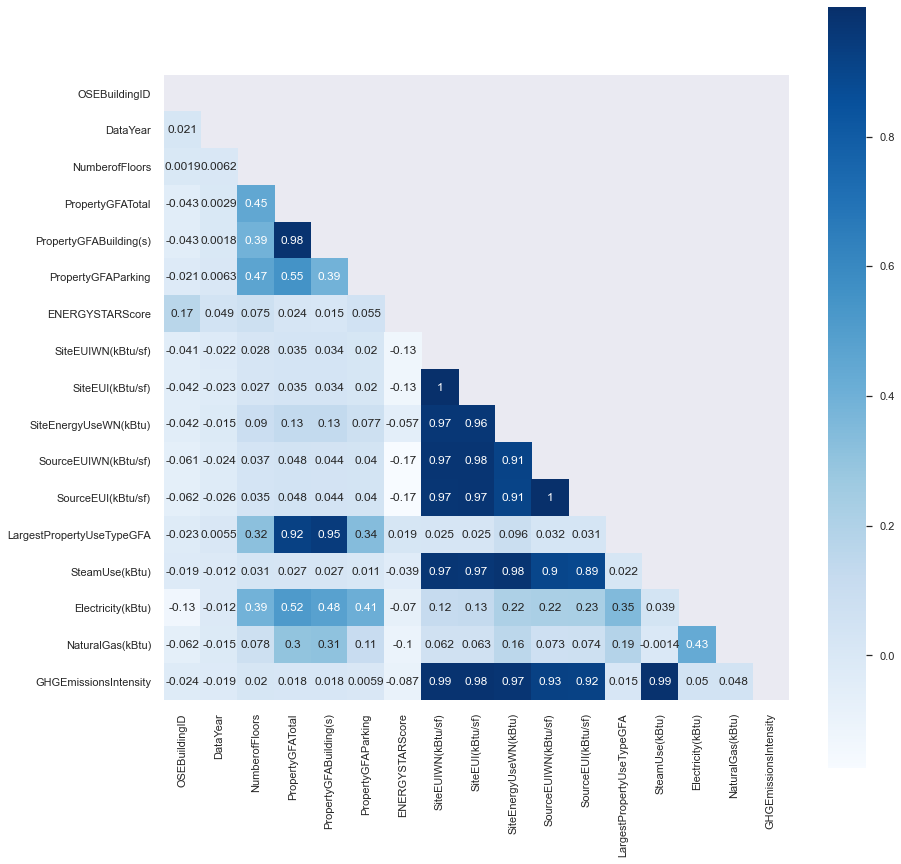

In [72]:
plt.figure(figsize = (14,14))
mask = np.zeros_like(NumImputedNoTarget.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(NumImputedNoTarget.corr(), cmap='Blues', annot=True, square=True, mask=mask, 
            cbar=True, vmin=None, vmax=None)

In [73]:
correlation = NumImputed.corr()
correlation.columns.value_counts().sum().sum()

17

In [74]:
list(correlation.columns)

['OSEBuildingID',
 'DataYear',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'ENERGYSTARScore',
 'SiteEUIWN(kBtu/sf)',
 'SiteEUI(kBtu/sf)',
 'SiteEnergyUseWN(kBtu)',
 'SourceEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'LargestPropertyUseTypeGFA',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'GHGEmissionsIntensity']

In [75]:
new_col={'OSEBuildingID' : 1, 'DataYear' : 2, 'NumberofFloors' : 3, 'PropertyGFATotal' : 4,
         'PropertyGFABuilding(s)' : 5, 'PropertyGFAParking' : 6, 'ENERGYSTARScore' : 7, 
         'SiteEUIWN(kBtu/sf)' : 8, 'SiteEUI(kBtu/sf)' : 9, 'SiteEnergyUseWN(kBtu)' : 10,
         'SourceEUIWN(kBtu/sf)' : 11, 'SourceEUI(kBtu/sf)' : 12, 
         'LargestPropertyUseTypeGFA' : 13, 'SteamUse(kBtu)' : 14, 
         'Electricity(kBtu)' : 15, 'NaturalGas(kBtu)' : 16, 'GHGEmissionsIntensity' : 17}

In [76]:
correlation_new = correlation.rename(columns = new_col, inplace = True)

correlation_new = correlation.rename(index = new_col)
correlation_new.head(2)

1         2         3         4         5         6         7   \
1  1.000000  0.020757  0.001883 -0.042997 -0.042852 -0.021128  0.169106   
2  0.020757  1.000000  0.006169  0.002931  0.001847  0.006344  0.048770   

         8         9         10        11        12        13        14  \
1 -0.041173 -0.041768 -0.041805 -0.061353 -0.062409 -0.022702 -0.019061   
2 -0.021558 -0.023130 -0.014792 -0.024278 -0.026194  0.005519 -0.012113   

         15        16        17  
1 -0.130862 -0.061844 -0.023955  
2 -0.011869 -0.015344 -0.018905

In [77]:
hyper_correlation = []
#T = [[]]
for i in correlation_new.columns:
    for j in range(i+1, 18):
        if abs(correlation_new.loc[i,j]) > 0.98 and i != j :
            
            T = [i , j]
            hyper_correlation.append(T)
            
        
hyper_correlation = pd.DataFrame(hyper_correlation)
#hyper_correlation.rename(columns = {0 : "ligne", 1 : "colone"})
print(hyper_correlation)
print (hyper_correlation[0].unique())
print (hyper_correlation[1].unique())
#correlation.iloc[hyper_correlation[0].unique(), :].columns

    0   1
0   4   5
1   8   9
2   8  17
3   9  17
4  11  12
5  14  17
[ 4  8  9 11 14]
[ 5  9 17 12]


Les colones récodées par les numéros [ 4  8  9 11 14] sont très corrélé aux \
aux autres variables numériques de la base. Il y a donc un problème de correlation entre les
que nous corrigérons en supprimant ces variables.

In [78]:
to_delete1 = []
to_delete2 = []
for element in new_col.keys():
    if new_col[element] in [4,8,9,11,14]:
        to_delete1.append(element)
        
for element in new_col.keys():
    if new_col[element] in [5, 9, 17, 12]:
        to_delete2.append(element)    
print(to_delete1)
print(to_delete2)

['PropertyGFATotal', 'SiteEUIWN(kBtu/sf)', 'SiteEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)']
['PropertyGFABuilding(s)', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'GHGEmissionsIntensity']


Dans la suite, nous supprimerons toutes les features de la première liste sauf 'SiteEUI(kBtu/sf)'. En effet,
**SiteEUIWN(kBtu/sf), 'SourceEUIWN(kBtu/sf)'** renseignent des énergies que le bâtiments aurait consommées dans les conditions normalisées des conditions météorologiques. Dans notre base, nous avons déjà des variables qui renseignent ces énergies réellement consommées par le bâtiment.
**PropretyGFATotal** renseigne sur la Surface brute de plancher totale du bâtiment et du parking.
**SteamUse(kBtu)** renseigne sur la quantité annuelle de vapeur de district consommée par la propriété sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).

In [79]:
### Suppression des variables trop corrélées
PropertyGFATotal=NumImputed['PropertyGFATotal']
SiteEUIWN=NumImputed['SiteEUIWN(kBtu/sf)']
SourceEUIWN=NumImputed['SourceEUIWN(kBtu/sf)']
SteamUse=NumImputed['SteamUse(kBtu)']
NumImputed.drop([
    'PropertyGFATotal',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'SteamUse(kBtu)']
,inplace=True,axis=1)

In [80]:
NumImputed.shape

(7209, 13)

## Correction des valeurs abérentes <a class="anchor" id="aberantes"></a>

BoxPlots pour repérer les valeurs abérentes

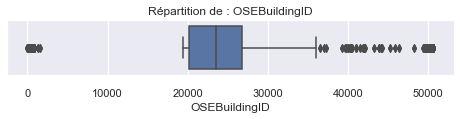

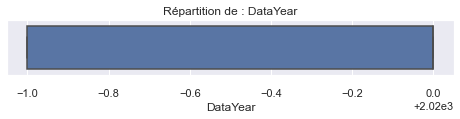

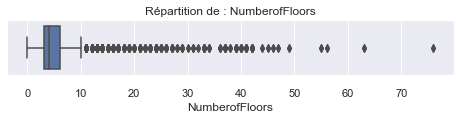

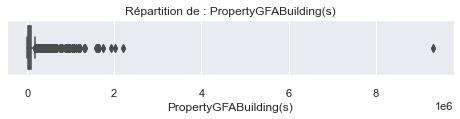

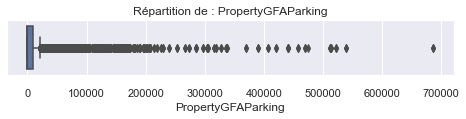

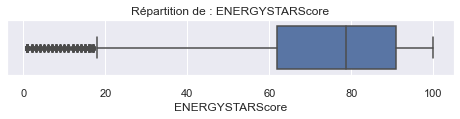

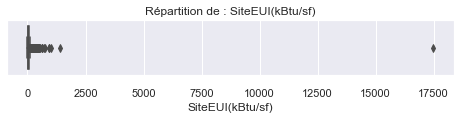

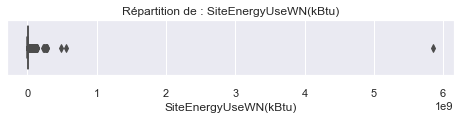

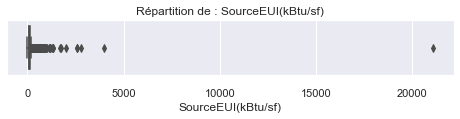

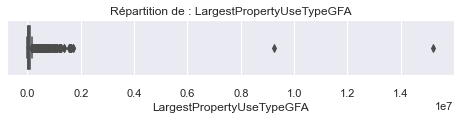

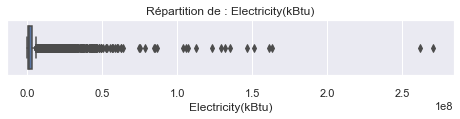

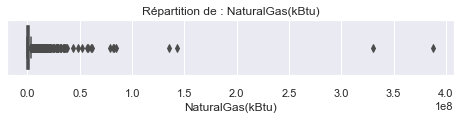

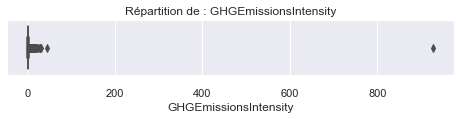

In [81]:
NumVarBoxPlot(NumImputed)

Les boxplots ci-dessus réalisés nous montrent que plusieurs variables possèdent des valeurs abérrentes. \
Nous isolerons ces variables dans la suite

In [82]:
def CorrectionAbValue(Data):
    for columns in Data:
        if (columns !='OSEBuildingID'):
            mediane = np.median(Data[columns])

            intqt = 1.5*(np.percentile(Data[columns], 75) - np.percentile(Data[columns], 25))
            lim_sup = intqt  + np.percentile(Data[columns], 75)
            lim_inf = np.percentile(Data[columns], 25) - intqt

            for ligne in Data[columns]:
                if (ligne > lim_sup or ligne < lim_inf):
                    Data[columns] = Data[columns].replace(ligne , mediane)

In [83]:
CorrectionAbValue(NumImputed) ## Une première correction

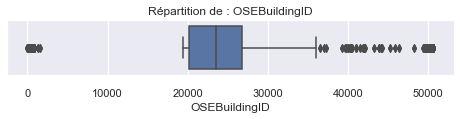

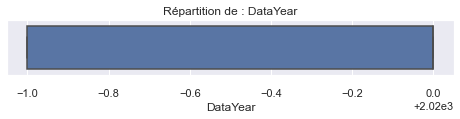

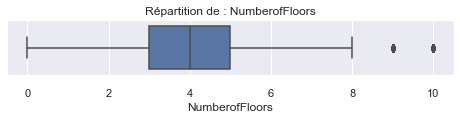

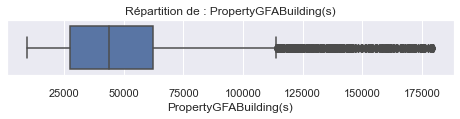

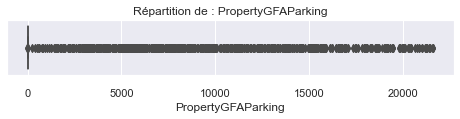

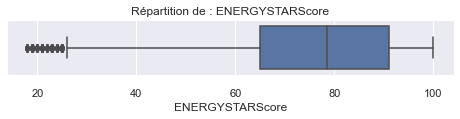

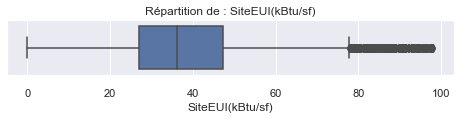

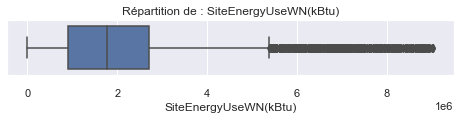

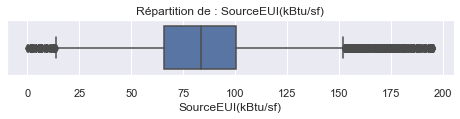

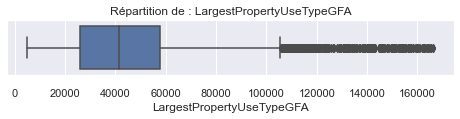

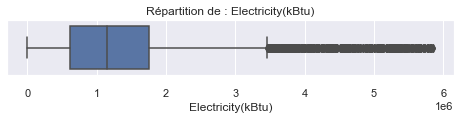

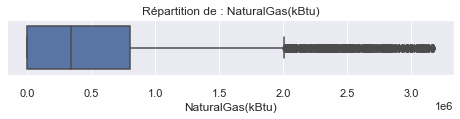

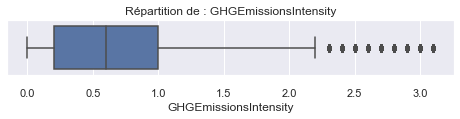

In [84]:
NumVarBoxPlot(NumImputed)

<p>On a toujours des valeurs abérentes, d'autres corrections seront faites pour ajuster ces valeurs.<br>Pour cela, nous avons créé la fonction suivante: </p>

In [85]:
## Fonction de répétition de la correction des valeurs abérentes
def CorrectionRepeat(Data,n):
    for i in range(n):
        CorrectionAbValue(Data)

In [86]:
CorrectionRepeat(NumImputed,2) ## 2 nouvelles corrections

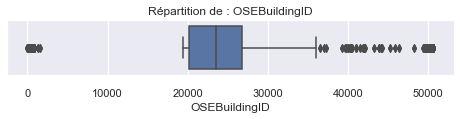

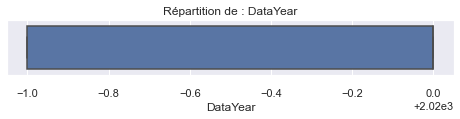

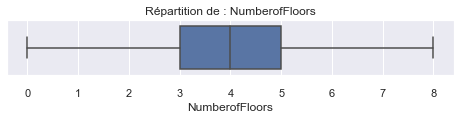

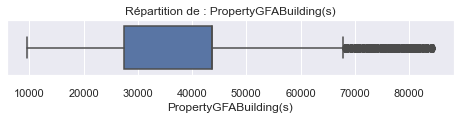

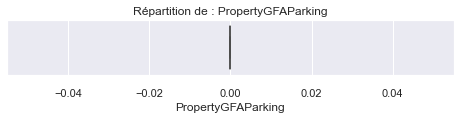

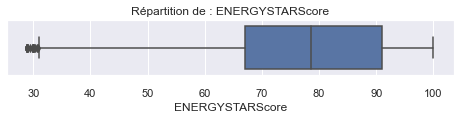

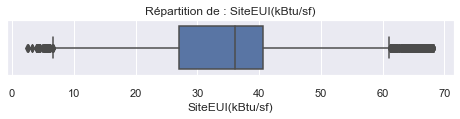

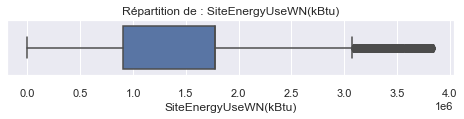

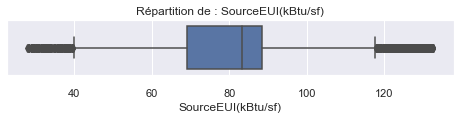

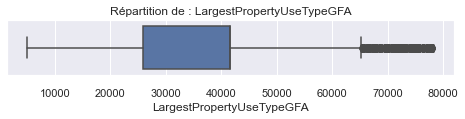

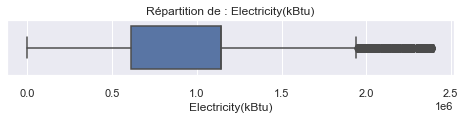

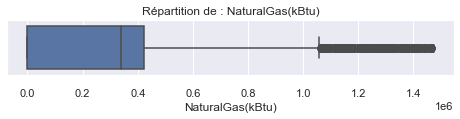

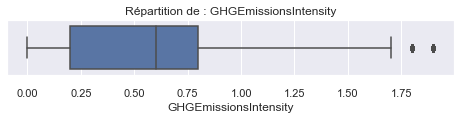

In [87]:
NumVarBoxPlot(NumImputed)

Il y a toujours des valeurs abérentes. Corrigeons deux fois de plus

In [88]:
CorrectionRepeat(NumImputed,2) ## 2 nouvelles corrections

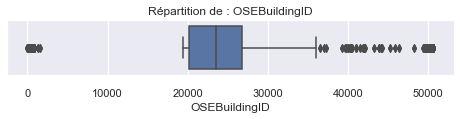

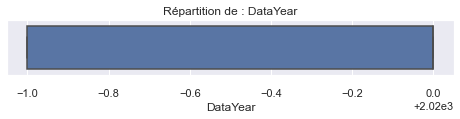

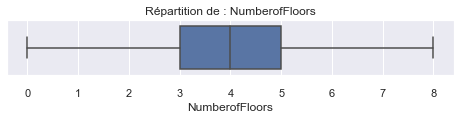

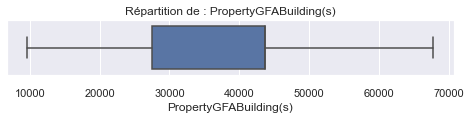

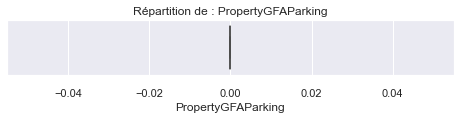

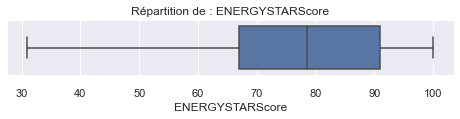

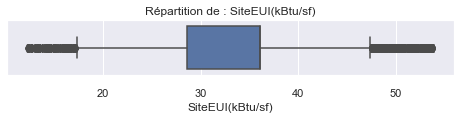

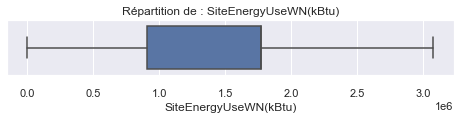

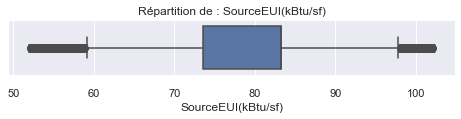

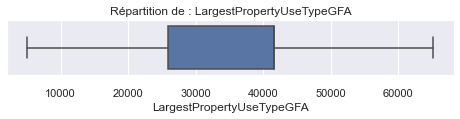

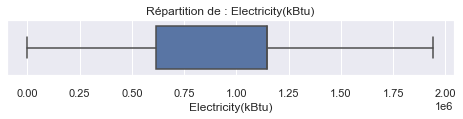

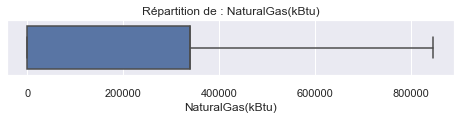

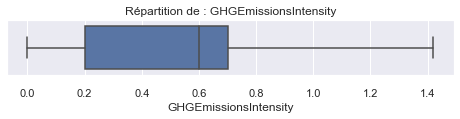

In [89]:
NumVarBoxPlot(NumImputed)

In [90]:
categorial_variables_modalities(CategorialData)

Multifamily          3815
NonResidential       3104
SPS-District K-12     198
Campus                 92
Name: BuildingType, dtype: int64
___________________________________________________________________________
DOWNTOWN                  1218
EAST                       971
MAGNOLIA / QUEEN ANNE      903
GREATER DUWAMISH           741
NORTHEAST                  645
LAKE UNION                 557
NORTHWEST                  441
SOUTHWEST                  355
NORTH                      302
BALLARD                    281
CENTRAL                    221
SOUTHEAST                  205
Autres_Neighborhood        202
DELRIDGE NEIGHBORHOODS     167
Name: Neighborhood, dtype: int64
___________________________________________________________________________
Multifamily Housing              3798
Autres_LargestPropertyUseType    1059
Office                           1031
Non-Refrigerated Warehouse        328
K-12 School                       285
Hotel                             171
Retail Store    

### Encodage des variables catégorielles en numerical features <a class="anchor" id="encodage"></a>

Les algorithmes d'apprentissage automatique ne peuvent pas travailler avec des données catégorielles directement, les données catégorielles doivent être converties en nombre. Pour cela, nous ferons appel aux méthodes d'encodage. Nous citons ci-après quelques-uns:

    1- Label Encoding (Encodage des étiquettes)
    2- One hot encoding (Encodage à chaud)
    3- Dummy variable trap (Encodage par variable fictive)
    4- Target encoding (Encodage de la cible)
    
Le **Label Encoding** consiste à transformer les modalités des variables en forme numérique afin que les algorithmes puissent comprendre comment opérer sur elles.

Un **One hot encoding** est une représentation des variables catégorielles sous forme de vecteurs binaires, ce qui permet de représenter les données catégorielles de manière plus expresive. Il faut d'abord que les valeurs catégorielles soient mappées en valeurs entières, c'est l'encodage par Label. Ensuite, chaque valeur entière est représentée comme un vecteur binaire composé de toutes les valeurs nulles, à l'exception de l'indice de l'entier, qui est marqué d'un 1.

Le piège de la **Dummy variable trap** est un scénario dans lequel les variables indépendantes sont multicolinéaires, un scénario dans lequel deux variables ou plus sont fortement corrélées, en termes simples : une variable peut être prédite à partir des autres.

En utilisant la fonction **pd.get_dummies**, nous pouvons effectuer les trois étapes ci-dessus en une seule ligne de code. Nous utiliserons cette fonction pour obtenir une variable fictive pour les caractéristiques sexe, enfants, fumeur, région. En définissant drop_first =True, la fonction supprimera le piège des variables fictives en supprimant une variable et la variable originale.

Le **Target encoding**
Dans le cas d'une cible catégorique, les caractéristiques sont remplacées par un mélange de la probabilité postérieure de la cible, compte tenu d'une valeur catégorique particulière, et de la probabilité antérieure de la cible sur toutes les données d'apprentissage.

<br>Se référer à ``category_encoders`` pour plus de détails ou à ce kaggle [link](https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark) 

Dans le cadre de ce projet, nous utiliserons le ``pd.get_dummies`` pour transformer nos variables targets.

In [91]:
CategorialData_encode = pd.get_dummies(data=CategorialData, prefix='OHE', prefix_sep='_',
                          columns=CategorialData.columns,
                          drop_first=False,
                          dtype='int8',
                         )
CategorialData_encode

OHE_Campus  OHE_Multifamily  OHE_NonResidential  OHE_SPS-District K-12  \
0              0                0                   1                      0   
1              0                0                   1                      0   
2              0                0                   1                      0   
3              0                0                   1                      0   
4              0                0                   1                      0   
...          ...              ...                 ...                    ...   
3623           0                0                   1                      0   
3624           0                1                   0                      0   
3625           0                0                   1                      0   
3626           0                1                   0                      0   
3627           0                1                   0                      0   

      OHE_Autres_Neighborhood  OHE_BALLARD  OHE_CENTRAL  \
0                           0            0            0   
1                           0            0            0   
2                           0            0            0   
3                           0            0            0   
4                           0            0            0   
...                       ...          ...          ...   
3623                        0            0            0   
3624                        0            0            0   
3625                        0            0            0   
3626                        0            0            1   
3627                        0            1            0   

      OHE_DELRIDGE NEIGHBORHOODS  OHE_DOWNTOWN  OHE_EAST  ...  OHE_Other  \
0                              0             1         0  ...          0   
1                              0             1         0  ...          0   
2                              0             1         0  ...          0   
3                              0             1         0  ...          0   
4                              0             1         0  ...          0   
...                          ...           ...       ...  ...        ...   
3623                           0             0         0  ...          0   
3624                           0             0         0  ...          0   
3625                           0             0         0  ...          0   
3626                           0             0         0  ...          0   
3627                           0             0         0  ...          0   

      OHE_Retail Store  OHE_Worship Facility  OHE_Autres_ComplianceStatus  \
0                    0                     0                            0   
1                    0                     0                            0   
2                    0                     0                            0   
3                    0                     0                            0   
4                    0                     0                            0   
...                ...                   ...                          ...   
3623                 0                     0                            0   
3624                 0                     0                            0   
3625                 0                     0                            0   
3626                 0                     0                            0   
3627                 0                     0                            0   

      OHE_Compliant  OHE_Not Compliant  OHE_Account Requires Verification  \
0                 1                  0                                  0   
1                 1                  0                                  0   
2                 1                  0                                  0   
3                 1                  0                                  0   
4                 1                  0                                  0   
...             ...                .

In [92]:
CleanedData=pd.concat([NumImputed,CategorialData_encode,target],axis=1)

In [93]:
CleanedData

OSEBuildingID  DataYear  NumberofFloors  PropertyGFABuilding(s)  \
0               1.0    2019.0             4.0                 43645.0   
1               2.0    2019.0             4.0                 43645.0   
2               3.0    2019.0             4.0                 43645.0   
3               5.0    2019.0             4.0                 61320.0   
4               8.0    2019.0             4.0                 43645.0   
...             ...       ...             ...                     ...   
3623        50690.0    2020.0             6.0                 43645.0   
3624        50692.0    2020.0             7.0                 43645.0   
3625        50693.0    2020.0             3.0                 20289.0   
3626        50694.0    2020.0             7.0                 43645.0   
3627        50697.0    2020.0             6.0                 43645.0   

      PropertyGFAParking  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                    0.0             62.0              36.1   
1                    0.0             70.0              36.1   
2                    0.0             64.0              36.1   
3                    0.0             58.0              36.1   
4                    0.0             63.0              36.1   
...                  ...              ...               ...   
3623                 0.0             84.0              36.1   
3624                 0.0             67.2              27.5   
3625                 0.0             50.4              36.1   
3626                 0.0             74.0              47.9   
3627                 0.0             98.0              25.5   

      SiteEnergyUseWN(kBtu)  SourceEUI(kBtu/sf)  LargestPropertyUseTypeGFA  \
0                 1773587.0                83.3                    41615.0   
1                 1773587.0                83.3                    41615.0   
2                 1773587.0                83.3                    41615.0   
3                 1773587.0                83.3                    61320.0   
4                 1773587.0                83.3                    41615.0   
...                     ...                 ...                        ...   
3623              1773587.0                83.3                    41615.0   
3624              1773587.0                70.9                    41615.0   
3625              2111309.0                83.3                    18289.0   
3626              1773587.0                85.3                    41615.0   
3627              1773587.0                55.8                    41615.0   

      ...  OHE_Worship Facility  OHE_Autres_ComplianceStatus  OHE_Compliant  \
0     ...                     0                            0              1   
1     ...                     0                            0              1   
2     ...                     0                            0              1   
3     ...                     0                            0              1   
4     ...                     0                            0              1   
...   ...                   ...                          ...            ...   
3623  ...                     0                            0              1   
3624  ...                     0                            0              1   
3625  ...                     0                            0              1   
3626  ...                     0                            0              1   
3627  ...                     0                            0              1   

      OHE_Not Compliant  OHE_Account Requires Verification  \
0                     0                                  0   
1                     0                                  0   
2                     0                                  0   
3                     0                                  0   
4                     0                                  0   
...                 ...                                ...   
3623                  0                             

## Exportation de la base propre <a class="anchor" id="export"></a>

In [94]:
CleanedData.to_csv('Clean_Data.csv', index=False)